In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch_dct as dct

from lib.tools import *
from lib.jpeg import *
from lib.decomposition import *
from lib.regression import *
from lib.sketchml import *

# Low rank tensor

In [2]:
import random
random.seed(5)

In [3]:
tensor_size  = 128*128*3

In [4]:
tensor = torch.zeros([128,128*3])

for i in range(128):
    a = random.random()
    b = random.random()*2
    c = random.random()
    for j in range(128*3):
        index = j /(128*3)
        if random.random()>0.2:
            tensor[i][j] = a*index -b*index*index+c*index*index*index+ random.random()/10
tensor = tensor.reshape([128,128,3])

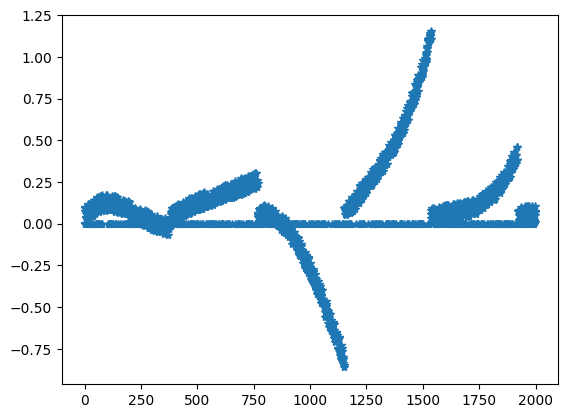

In [5]:
plt.figure()
plt.plot(tensor.reshape(tensor.numel())[0:2000],"*")

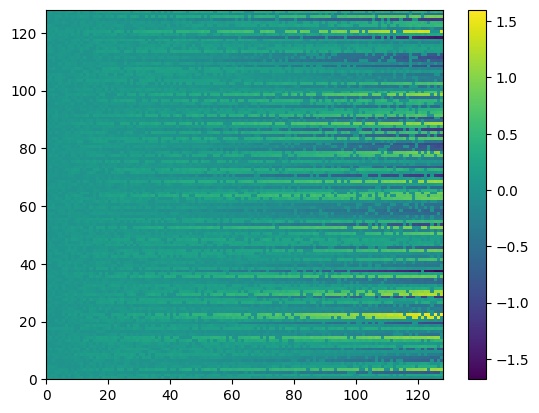

In [6]:
plt.figure()
plt.pcolormesh(tensor[:,:,0])
plt.colorbar()

## Get tensor charateristics

In [7]:
# actual_rank= calculate_cp_rank(tensor.numpy())
# print("The acutal rank of the tensor is: ", actual_rank)

In [8]:
sparsity = calculate_sparsity(tensor.numpy())
print("The sparsity of the tensor is: ", sparsity)

The sparsity of the tensor is:  0.19840494791666666


## Tensor compression

#### Jpeg

In [9]:
lowrank_jpeg_ratio = []
lowrank_jpeg_snr =[]
lowrank_jpeg_mse = []

In [10]:
for i in range(10):
    jpeg_quality = 55 + i *5
    normalize_base, scale,zero_point, encoded_data, compressed_size_jpeg = compressor_jpeg(tensor, jpeg_quality)
    print("Compressed size: ", compressed_size_jpeg)

    reconstructed_tensor_jpeg = decompressor_jpeg(tensor.shape,normalize_base, scale,zero_point, encoded_data )
    snr_jpeg = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_jpeg.numpy())
    mse_jpeg = calculate_mse(tensor.numpy(), reconstructed_tensor_jpeg.numpy())
    print("Reconstruction snr (dB): ", snr_jpeg)
    print("Reconstruction mse: ", mse_jpeg)
    
    lowrank_jpeg_ratio.append((tensor_size*4) / compressed_size_jpeg)
    lowrank_jpeg_snr.append(snr_jpeg)
    lowrank_jpeg_mse.append(mse_jpeg / torch.max(tensor).item())

Compressed size:  3032
Reconstruction snr (dB):  6.982178092002869
Reconstruction mse:  0.018508427
Compressed size:  3246
Reconstruction snr (dB):  7.127674221992493
Reconstruction mse:  0.017898632
Compressed size:  3555
Reconstruction snr (dB):  7.288079261779785
Reconstruction mse:  0.017249614
Compressed size:  4013
Reconstruction snr (dB):  7.495158910751343
Reconstruction mse:  0.01644642
Compressed size:  4565
Reconstruction snr (dB):  7.786705493927002
Reconstruction mse:  0.015378597
Compressed size:  5555
Reconstruction snr (dB):  8.28442931175232
Reconstruction mse:  0.013713376
Compressed size:  7048
Reconstruction snr (dB):  9.262597560882568
Reconstruction mse:  0.010947816
Compressed size:  9804
Reconstruction snr (dB):  11.156306266784668
Reconstruction mse:  0.0070787524
Compressed size:  15922
Reconstruction snr (dB):  15.075592994689941
Reconstruction mse:  0.0028709657
Compressed size:  35915
Reconstruction snr (dB):  28.916006088256836
Reconstruction mse:  0.00011

#### Tensor decomposition

In [11]:
lowrank_decomposition_ratio =[]
lowrank_decomposition_snr = []
lowrank_decomposition_mse = []

In [12]:
for i in range(20):
    decom_rank_ratio = 0.05*(i+1) +0.5
    factors, compressed_size_decomposition = compressor_decomposition_slice_quality(tensor,decom_rank_ratio)
    print("Compressed size: ", compressed_size_decomposition)
    reconstructed_tensor_decomposition = decompressor_decomposition_slice(tensor.shape, factors )
    snr_decomposition = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_decomposition.numpy())
    mse_decomposition = calculate_mse(tensor.numpy(), reconstructed_tensor_decomposition.numpy())
    print("Reconstruction snr (dB): ", snr_decomposition)
    print("Reconstruction mse: ", mse_decomposition)

    lowrank_decomposition_ratio.append((tensor_size*4) / compressed_size_decomposition)
    lowrank_decomposition_snr.append(snr_decomposition)
    lowrank_decomposition_mse.append(mse_decomposition / torch.max(tensor).item())

Compressed size:  134144
Reconstruction snr (dB):  12.60001540184021
Reconstruction mse:  0.0050767497
Compressed size:  134144
Reconstruction snr (dB):  12.60001540184021
Reconstruction mse:  0.0050767497
Compressed size:  134144
Reconstruction snr (dB):  12.60001540184021
Reconstruction mse:  0.0050767497
Compressed size:  134144
Reconstruction snr (dB):  12.60001540184021
Reconstruction mse:  0.0050767497
Compressed size:  134144
Reconstruction snr (dB):  12.60001540184021
Reconstruction mse:  0.0050767497
Compressed size:  134144
Reconstruction snr (dB):  12.60001540184021
Reconstruction mse:  0.0050767497
Compressed size:  201216
Reconstruction snr (dB):  136.98442459106445
Reconstruction mse:  1.8498835e-15
Compressed size:  201216
Reconstruction snr (dB):  136.98442459106445
Reconstruction mse:  1.8498835e-15
Compressed size:  201216
Reconstruction snr (dB):  136.98442459106445
Reconstruction mse:  1.8498835e-15
Compressed size:  201216
Reconstruction snr (dB):  136.984424591064

#### Regression

In [13]:
lowrank_regression_ratio = []
lowrank_regression_snr = []
lowrank_regression_mse = []

In [14]:
for i in range(10):
    regression_rank = i+1
    factors, x_pos, x_neg, compressed_size_regression = compressor_regression(tensor, regression_rank)
    print("Compressed size: ", compressed_size_regression)

    reconstructed_tensor_regression = decompressor_regression(tensor.shape, factors, x_pos,x_neg )
    snr_regression = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_regression.numpy())
    mse_regression = calculate_mse(tensor.numpy(), reconstructed_tensor_regression.numpy())
    print("Reconstruction snr (dB): ", snr_regression)
    print("Reconstruction mse: ", mse_regression)

    lowrank_regression_ratio.append((tensor_size*4) / compressed_size_regression)
    lowrank_regression_snr.append(snr_regression)
    lowrank_regression_mse.append(mse_regression / torch.max(tensor).item())

Compressed size:  12800.0
Reconstruction snr (dB):  13.287986516952515
Reconstruction mse:  0.0043329992
Compressed size:  13312.0
Reconstruction snr (dB):  19.237953424453735
Reconstruction mse:  0.0011010118
Compressed size:  13824.0
Reconstruction snr (dB):  20.91989517211914
Reconstruction mse:  0.0007474767
Compressed size:  14336.0
Reconstruction snr (dB):  21.350417137145996
Reconstruction mse:  0.000676933
Compressed size:  14848.0
Reconstruction snr (dB):  21.549067497253418
Reconstruction mse:  0.0006466666
Compressed size:  15360.0
Reconstruction snr (dB):  21.639738082885742
Reconstruction mse:  0.0006333058
Compressed size:  15872.0
Reconstruction snr (dB):  21.684770584106445
Reconstruction mse:  0.0006267729
Compressed size:  16384.0
Reconstruction snr (dB):  21.720404624938965
Reconstruction mse:  0.0006216512
Compressed size:  16896.0
Reconstruction snr (dB):  21.74288272857666
Reconstruction mse:  0.0006184419
Compressed size:  17408.0
Reconstruction snr (dB):  21.766

#### Sketch ML

In [19]:
lowrank_sketchml_ratio = []
lowrank_sketchml_snr = []
lowrank_sketchml_mse = []

In [20]:
for i in range (10):
    d = (i+1) * 0.1
    a = round(2+0.2*i)
    minmaxsketch,bucket_means, keys, compressed_size_sketchml = compressor_sketchml(tensor,128,d,a)
    print("Compressed size: ", compressed_size_sketchml)

    reconstructed_tensor_sketchml = decompressor_sketchml(tensor.shape, minmaxsketch,bucket_means, keys)
    snr_sketchml = calculate_snr(tensor_size,tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    mse_sketchml = calculate_mse(tensor.numpy(), reconstructed_tensor_sketchml.numpy())
    print("Reconstruction snr (dB): ", snr_sketchml)
    print("Reconstruction mse: ", mse_sketchml)
    
    lowrank_sketchml_ratio.append((tensor_size*4) / compressed_size_sketchml)
    lowrank_sketchml_snr.append(snr_sketchml)
    lowrank_sketchml_mse.append( mse_sketchml / torch.max(tensor).item())

Compressed size:  8980
Reconstruction snr (dB):  -3.718324899673462
Reconstruction mse:  0.21748023
Compressed size:  16885
Reconstruction snr (dB):  -0.9809272736310959
Reconstruction mse:  0.115792386
Compressed size:  24778
Reconstruction snr (dB):  0.8018357306718826
Reconstruction mse:  0.076807514
Compressed size:  48972
Reconstruction snr (dB):  4.340205192565918
Reconstruction mse:  0.03400688
Compressed size:  60732
Reconstruction snr (dB):  5.6401896476745605
Reconstruction mse:  0.02520974
Compressed size:  72555
Reconstruction snr (dB):  7.102729082107544
Reconstruction mse:  0.018001737
Compressed size:  84375
Reconstruction snr (dB):  8.022688627243042
Reconstruction mse:  0.014565267
Compressed size:  96192
Reconstruction snr (dB):  9.17655885219574
Reconstruction mse:  0.011166868
Compressed size:  144012
Reconstruction snr (dB):  12.638527154922485
Reconstruction mse:  0.0050319303
Compressed size:  159784
Reconstruction snr (dB):  13.594496250152588
Reconstruction mse

# Plot

Text(0, 0.5, 'Reconstruction SNR [dB]')

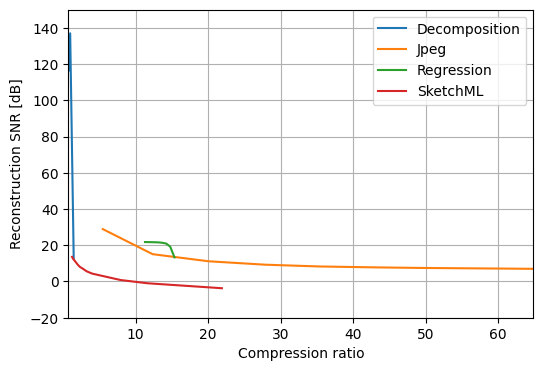

In [21]:
plt.figure(figsize=(6,4))
plt.plot(lowrank_decomposition_ratio, lowrank_decomposition_snr,label ="Decomposition")
plt.plot(lowrank_jpeg_ratio, lowrank_jpeg_snr,label ="Jpeg")
plt.plot(lowrank_regression_ratio, lowrank_regression_snr,label ="Regression")
plt.plot(lowrank_sketchml_ratio, lowrank_sketchml_snr,label ="SketchML")
plt.legend()
plt.grid()
plt.ylim([-20,150])
plt.autoscale(axis='x',tight=True)
plt.xlabel("Compression ratio")
plt.ylabel("Reconstruction SNR [dB]")

# Plotting